In [103]:
%pip install -q -U langchain_core langgraph langchain-google-genai

In [104]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [105]:
import os

os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"


In [106]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-1.5-flash")

In [107]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

class State(MessagesState):
    summary: str


def call_model(state: State) -> State:
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages)

    return {"messages": response}

In [108]:
def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

In [109]:
from langgraph.graph import END

def should_continue(state: State):
    messages = state["messages"]

    if len(messages) > 6:
        return "Summarization Node"

    return END

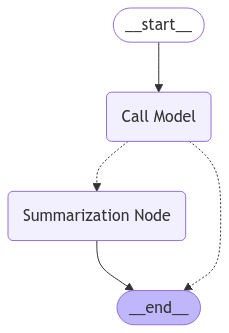

In [110]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image, display

builder: StateGraph = StateGraph(State)

builder.add_node("Call Model", call_model)
builder.add_node("Summarization Node", summarize_conversation)

builder.add_edge(START, "Call Model")
builder.add_conditional_edges("Call Model", should_continue)
builder.add_edge("Summarization Node", END)

memory: MemorySaver = MemorySaver()

graph: CompiledStateGraph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [111]:
config = {"configurable": {"thread_id": "1"}}

output = graph.invoke({"messages": [HumanMessage(content="Hi! I'm Sarfaraz")]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

output = graph.invoke({"messages": [HumanMessage(content="What's my name?")]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Sarfaraz!  It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Sarfaraz.


In [112]:
graph.get_state(config).values.get("summary", "")

''

In [113]:
output = graph.invoke({"messages": [HumanMessage(content="I am learning langchain in python")]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

output = graph.invoke({"messages": [HumanMessage(content="why is the sky blue")]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

That's great! Langchain is a powerful and versatile framework.  What specifically are you working on or what questions do you have about LangChain in Python?  Knowing your current stage and specific challenges will help me provide more relevant assistance.  For example, are you:

* **Just starting out and learning the basics?**  (e.g., setting up the environment, understanding the core concepts like chains and indexes)
* **Working on a specific project?** (e.g., building a chatbot, a question-answering system, a document summarizer)
* **Troubleshooting a particular problem?** (e.g., getting an error message, struggling with a specific LLM integration)

The more details you provide, the better I can help.
================================== Ai Message ==================================

The sky is blue due to a phenomenon called **Rayleigh scattering**.  Sunlight is made up of all the colors of the rainbow.

In [114]:
graph.get_state(config).values.get("summary","")

'The conversation began with introductions, where I identified the user as Sarfaraz.  Sarfaraz then stated he was learning Langchain in Python, prompting me to ask for specifics about his learning process or challenges to offer better assistance.  Finally, Sarfaraz asked why the sky is blue, and I explained the scientific reason: Rayleigh scattering of sunlight by air molecules, which preferentially scatters blue and violet light.\n'